In [1]:
import import_ipynb
import darknet
import util
import dataset_loader

import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import math
import warnings
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings('ignore')

importing Jupyter notebook from darknet.ipynb
import import_ipynb
import darknet
import util
import dataset_loader

import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import math
import warnings
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings('ignore')
importing Jupyter notebook from util.ipynb
importing Jupyter notebook from dataset_loader.ipynb


In [2]:
anchors = [
    [1.08, 1.19],
    [3.42, 4.41],
    [6.63, 11.38],
    [9.42, 5.11],
    [16.62, 10.52]
]

scaled_anchors = torch.cuda.FloatTensor([(a_w / 32, a_h /32) for a_w, a_h in anchors])

In [3]:
classes = [
'aeroplane',
'bicycle',
'bird',
'boat',
'bottle',
'bus',
'car',
'cat',
'chair',
'cow',
'diningtable',
'dog',
'horse',
'motorbike',
'person',
'pottedplant',
'sheep',
'sofa',
'train',
'tvmonitor']

In [4]:
def build_targets(target, anchors, grid_size, num_anchors=5, num_classes = 20):
    
    nB = target.size(0) # number of batches
    nA = num_anchors # number of anchors
    nC = num_classes # number of classes
    nG = grid_size # grid size of the target
    
    mask = torch.zeros(nB, nA, nG, nG)
    no_mask = torch.ones(nB, nA, nG, nG)
    
    
    tx = torch.zeros(nB, nA, nG, nG) # center x for each grid
    ty = torch.zeros(nB, nA, nG, nG) # center y for each grid
    tw = torch.zeros(nB, nA, nG, nG) # width for each grid
    th = torch.zeros(nB, nA, nG, nG) # height for each grid
    tconf = torch.zeros(nB, nA, nG, nG) # confidence for each grid
    tcls = torch.zeros(nB, nA, nG, nG, nC) # 20 classes for each grid
    
    
    for b in range(nB):  # for each image
        for t in range(target.shape[1]):  # for each object
            if target[b, t].sum() == 0:  # if the row is empty
                continue
            
            # Convert to object label data to feature map
            # single coord value * the grid corresponding it
            gx = target[b, t, 1] * nG 
            gy = target[b, t, 2] * nG
            gw = target[b, t, 3] * nG
            gh = target[b, t, 4] * nG
            # Get grid box indices
            gi = int(gx)
            gj = int(gy)
            # Get shape of gt box
            gt_box = torch.FloatTensor(np.array([0, 0, gw, gh])).unsqueeze(0)  # 1 x 4
            # Get shape of anchor box
            anchor_shapes = torch.FloatTensor(
                np.concatenate((np.zeros((len(anchors), 2)), np.array(anchors)), 1))
            # Calculate iou between gt and anchor shapes
            # See which anchor fits the best with the existing height and width of the object
            anch_ious = util.bbox_iou(gt_box, anchor_shapes)
            
            # Find the best matching anchor box
            best_n = np.argmax(anch_ious)
            # Masks
            # for the mask that has the best anchor
            # for the grid that contain the center of the object
            # mask is activated
            # [b, anchors, grid, grid] -> activate the grid cell on the anchor that has the object
            mask[b, best_n, gi, gj] = 1
            no_mask[b, best_n, gi, gj] = 0
            # Coordinates
            # Coordinates are normalized for each grid
            tx[b, best_n, gi, gj] = gx - gi
            ty[b, best_n, gi, gj] = gy - gj
            # Width and height
            # Normalize the width and height relative to the anchor used 
            tw[b, best_n, gi, gj] = math.log(gw / anchors[best_n][0] + 1e-16)
            th[b, best_n, gi, gj] = math.log(gh / anchors[best_n][1] + 1e-16)
            # One-hot encoding of label
            target_label = int(target[b, t, 0])
            tcls[b, best_n, gi, gj, target_label] = 1
            tconf[b, best_n, gi, gj] = 1
            
            
    return mask, no_mask, tx, ty, tw, th, tconf, tcls

In [5]:
def Loss(input, target, anchors, inp_dim, num_anchors = 5, num_classes = 20):

    nA = num_anchors  # number of anchors
    nB = input.size(0)  # number of batches
    nG = input.size(2)  # number of grid size
    nC = num_classes
    stride = inp_dim // nG
    
    # Tensors for cuda support
    FloatTensor = torch.cuda.FloatTensor if input.is_cuda else torch.FloatTensor
    ByteTensor = torch.cuda.ByteTensor if input.is_cuda else torch.ByteTensor
    prediction = input
    
    # Get outputs
    x = torch.sigmoid(prediction[..., 0])  # Center x
    y = torch.sigmoid(prediction[..., 1])  # Center y
    w = prediction[..., 2]  # Width
    h = prediction[..., 3]  # Height
    pred_conf = torch.sigmoid(prediction[..., 4])  # Conf
    pred_cls = prediction[..., 5:]  # Cls pred

    mask, no_mask, tx, ty, tw, th, tconf, tcls = build_targets(
        target=target.cpu().data,
        anchors=scaled_anchors.cpu().data,
        grid_size=nG,
        num_anchors=nA,
        num_classes=num_classes)
    
    
    
    # Handle target variables
    tx, ty = tx.type(FloatTensor), ty.type(FloatTensor)
    tw, th = tw.type(FloatTensor), th.type(FloatTensor)
    tconf, tcls = tconf.type(FloatTensor), tcls.type(FloatTensor)
    
    mask = mask.type(ByteTensor)
    no_mask = no_mask.type(ByteTensor)
    
    mse_loss = nn.MSELoss(reduction='sum')  # Coordinate loss
    bce_loss = nn.BCELoss(reduction='sum')  # Confidence loss
    ce_loss = nn.CrossEntropyLoss(reduction='sum')
    
    loss_x = mse_loss(x[mask], tx[mask])
    loss_y = mse_loss(y[mask], ty[mask])
    loss_w = mse_loss(w[mask], tw[mask])
    loss_h = mse_loss(h[mask], th[mask])
    loss_conf = bce_loss(pred_conf[mask], tconf[mask]) * 5
    loss_conf_noobj = bce_loss(pred_conf[no_mask], tconf[no_mask])
    loss_cls = ce_loss(pred_cls[mask], torch.argmax(tcls[mask], dim=1))
    loss = loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls + loss_conf_noobj

    return loss, loss_x, loss_y, loss_w, loss_h, loss_conf, loss_cls, loss_conf_noobj

In [6]:
dataloader = torch.utils.data.DataLoader(dataset_loader.VOCDataset
                                         (dataset_loader.IMG_PATH, 
                                          dataset_loader.IMG_TRAIN_TXT_PATH, 
                                          dataset_loader.ANNOT_TRAIN_PATH), 
                                         batch_size=64, 
                                         shuffle=True)

In [7]:
dark_net = darknet.DarkNet().to(device)
#dark_net.load_state_dict(torch.load(os.path.join(os.getcwd(), 'yolo_last.pth')))
darknet.load_weights('tiny-yolo-voc.weights', dark_net)
optimizer = torch.optim.Adam(dark_net.parameters(), lr=1e-5, weight_decay=5e-4)


DarkNet(
  (activation): LeakyReLU(negative_slope=0.1, inplace=True)
  (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool_2): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=2, ceil_mode=False)
  (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batch_norm_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batch_norm_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batch_norm_4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [8]:
def draw_grid(coords, image):
    
    for (x, y, w, h, _, name) in coords:
            #print(x, y, w, h, classes[name.item()])
            #print(classes[name])
            
            x1 = int(x.item())
            y1 = int(y.item())
            x2 = int(w.item())
            y2 = int(h.item())
            name = int(name.item())
            print(classes[name])
            image = cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
    return image

In [9]:
def box_ious(box1, box2):
    """
    Implement the intersection over union (IoU) between box1 and box2 (x1, y1, x2, y2)
    Arguments:
    box1 -- tensor of shape (N, 4), first set of boxes
    box2 -- tensor of shape (K, 4), second set of boxes
    Returns:
    ious -- tensor of shape (N, K), ious between boxes
    """

    N = box1.size(0)
    K = box2.size(0)

    # when torch.max() takes tensor of different shape as arguments, it will broadcasting them.
    xi1 = torch.max(box1[:, 0].view(N, 1), box2[:, 0].view(1, K))
    yi1 = torch.max(box1[:, 1].view(N, 1), box2[:, 1].view(1, K))
    xi2 = torch.min(box1[:, 2].view(N, 1), box2[:, 2].view(1, K))
    yi2 = torch.min(box1[:, 3].view(N, 1), box2[:, 3].view(1, K))

    # we want to compare the compare the value with 0 elementwise. However, we can't
    # simply feed int 0, because it will invoke the function torch(max, dim=int) which is not
    # what we want.
    # To feed a tensor 0 of same type and device with box1 and box2
    # we use tensor.new().fill_(0)

    iw = torch.max(xi2 - xi1, box1.new(1).fill_(0))
    ih = torch.max(yi2 - yi1, box1.new(1).fill_(0))

    inter = iw * ih

    box1_area = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    box2_area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

    box1_area = box1_area.view(N, 1)
    box2_area = box2_area.view(1, K)

    union_area = box1_area + box2_area - inter

    ious = inter / union_area

    return ious

In [10]:
def yolo_nms(boxes, scores, threshold):
    """
    Apply Non-Maximum-Suppression on boxes according to their scores
    Arguments:
    boxes -- tensor of shape (N, 4) (x1, y1, x2, y2)
    scores -- tensor of shape (N) confidence
    threshold -- float. NMS threshold
    Returns:
    keep -- tensor of shape (None), index of boxes which should be retain.
    """

    score_sort_index = torch.sort(scores, dim=0, descending=True)[1]

    keep = []

    while score_sort_index.numel() > 0:

        i = score_sort_index[0]
        keep.append(i)

        if score_sort_index.numel() == 1:
            break

        cur_box = boxes[score_sort_index[0], :].view(-1, 4)
        res_box = boxes[score_sort_index[1:], :].view(-1, 4)

        ious = box_ious(cur_box, res_box).view(-1)
        
        
        inds = torch.nonzero(ious < threshold).squeeze()

        score_sort_index = score_sort_index[inds + 1].view(-1)

    return torch.LongTensor(keep)

In [11]:
def predict_transform(input, anchors, hh, ww, inp_dim, confidence, num_anchors = 5, num_classes = 20):
    
    nG = input.shape[3]
    stride = inp_dim / nG
    prediction = input.contiguous().view(-1, nG * nG * num_anchors, 5 + num_classes)
    
    xy_pred = torch.sigmoid(prediction[:, :, 0:2])
    conf_pred = torch.sigmoid(prediction[:, :, 4:5]).squeeze(0)
    hw_pred = torch.exp(prediction[:, :, 2:4])
    
    # [B, G * G * num_anchors, 20]
    class_pred = torch.softmax(prediction[:, :, 5:], dim=2).squeeze(0)
    # [B, G * G * num_anchors, 4]
    delta_pred = torch.cat([xy_pred, hw_pred], dim=2).squeeze(0)
    
    deltas = delta_pred.cpu()
    classes = class_pred.cpu()
    conf = conf_pred.cpu()
    
    H = 13
    W = 13
    K = H * W
    anch = torch.FloatTensor(np.divide(anchors, 32))
    A = anch.size(0)
 
    # [13, 13] grid
    shift_x, shift_y = torch.meshgrid([torch.arange(0, W), torch.arange(0, H)])

    # transpose shift_x and shift_y because we want our anchors to be organized in H x W order
    shift_x = shift_x.t().contiguous()
    shift_y = shift_y.t().contiguous()

    # shift_x is a long tensor, c_x is a float tensor
    c_x = shift_x.float()
    c_y = shift_y.float()
    
    # tensor of shape (h * w, 2), (cx, cy)
    centers = torch.cat([c_x.view(-1, 1), c_y.view(-1, 1)], dim=-1)
    
    # add anchors width and height to centers
    all_anchors = torch.cat([centers.view(K, 1, 2).expand(K, A, 2),
                             anch.view(1, A, 2).expand(K, A, 2)], dim=-1)
    
    all_anchors = all_anchors.view(-1, 4)
    
    all_anchors_xywh = all_anchors
    
    c_x = all_anchors_xywh[:, 0] + deltas[:, 0]
    c_y = all_anchors_xywh[:, 1] + deltas[:, 1]
    w = all_anchors_xywh[:, 2] * deltas[:, 2]
    h = all_anchors_xywh[:, 3] * deltas[:, 3]

    c_x = c_x.view(-1, 1)
    c_y = c_y.view(-1, 1)
    w = w.view(-1, 1)
    h = h.view(-1, 1)

    pred_box = torch.cat([c_x, c_y, w, h], dim=-1)
    
    cls_max_conf, cls_max_id = torch.max(classes, dim=-1, keepdim=True)

    cls_conf = conf * cls_max_conf
    
    pos_inds = (cls_conf > confidence).view(-1)
    
    
    boxes = pred_box[pos_inds, :]
    conf = conf[pos_inds, :]
    cls_max_conf = cls_max_conf[pos_inds, :]
    cls_max_id = cls_max_id[pos_inds, :].float()

    # no detection !
    if boxes.size(0) == 0:
        print('no detection')
        return []
    
    scale_h, scale_w = 416 / hh, 416 / ww
    

    box = boxes * stride

    #box[:, 0::2] /= scale_w
    #box[:, 1::2] /= scale_h
    
    
    x1 = box[:, 0] - (box[:, 2]) / 2
    y1 = box[:, 1] - (box[:, 3]) / 2
    x2 = box[:, 0] + (box[:, 2]) / 2
    y2 = box[:, 1] + (box[:, 3]) / 2
    
    x1 = x1.view(-1, 1)
    y1 = y1.view(-1, 1)
    x2 = x2.view(-1, 1)
    y2 = y2.view(-1, 1)

    bbox = torch.cat([x1, y1, x2, y2], dim=1)
    nms = yolo_nms(bbox, conf.view(-1), 0.4)
    
    bbox = bbox[nms, :]
    conf = conf[nms, :]
    cls_max_id = cls_max_id[nms, :]
    
    # clamp boxes
    bbox[:, 0::2].clamp_(0, ww-1)
    bbox[:, 1::2].clamp_(0, hh-1)
    
    return torch.cat([bbox, conf, cls_max_id], dim=1)

In [12]:
def preprocess_image():
    path = os.path.join(os.getcwd(), 'doggo.jpg')
    img = cv2.imread(path)
    
    h, w, _ = img.shape
        
    # Dimension difference between height and width
    dim_diff = np.abs(h - w)

    # Upper (left) and lower (right) padding
    # [1, 2] padding means for [2, 2] ones matrix
    # [0, 0, 0, 0, 0]
    # [0, 1, 1, 0, 0]
    # [0, 1, 1, 0, 0]
    # [0, 0, 0, 0, 0]
    # [0, 0, 0, 0, 0]
    pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2

    # Determine padding
    pad = ((pad1, pad2), (0, 0), (0, 0)) if h <= w else ((0, 0), (pad1, pad2), (0, 0))
    # Add padding
    pad_img = np.pad(img, pad, 'constant', constant_values=128)
    padded_h, padded_w, _ = pad_img.shape

    # Resize the image to the Darknet input dimension
    pad_img = cv2.resize(pad_img, (416,416))
    # Channels-first
    input_img = pad_img.reshape((3, 416, 416))
    # As pytorch tensor
    input_img = torch.from_numpy(input_img).float().div(255.0)
    input_img = input_img.unsqueeze(0)
    
    return input_img.to(device), h, w

bird
bird
bird
bicycle
bicycle
boat
pottedplant
bus


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


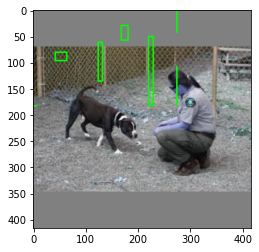

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def test_image():
    
    dark_net.eval()
    
    for m in list(dark_net.children()):
        if isinstance(m, nn.BatchNorm2d):
            m.track_running_stats = False
    
    with torch.no_grad():
        # Preprocess the input image [1, C, H, W]
        img, h, w = preprocess_image()
        img_orig = img.squeeze(0).cpu().reshape(416, 416, 3).contiguous().numpy()
        # Get the prediction for the image
        # [1, A, G, G, 25]
        pred = dark_net(img)
        pred = predict_transform(pred, anchors, h, w, 416, 0.55)
        pred = draw_grid(pred, img_orig) 
    
    for m in list(dark_net.children()):
        if isinstance(m, nn.BatchNorm2d):
            m.track_running_stats = True
    dark_net.train()       
    return pred

img = test_image()
plt.imshow(img)

In [14]:
def non_max_suppression(prediction, conf_thres=0.5, nms_thres=0.4):
    """
    Removes detections with lower object confidence score than 'conf_thres' and performs
    Non-Maximum Suppression to further filter detections.
    Returns detections with shape:
        (x1, y1, x2, y2, object_conf, class_score, class_pred)
    """

    # From (center x, center y, width, height) to (x1, y1, x2, y2)
    prediction[..., :4] = xywh2xyxy(prediction[..., :4])
    output = [None for _ in range(len(prediction))]
    for image_i, image_pred in enumerate(prediction):
        # Filter out confidence scores below threshold
        image_pred = image_pred[image_pred[:, 4] >= conf_thres]
        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Object confidence times class confidence
        score = image_pred[:, 4] * image_pred[:, 5:].max(1)[0]
        # Sort by it
        image_pred = image_pred[(-score).argsort()]
        class_confs, class_preds = image_pred[:, 5:].max(1, keepdim=True)
        detections = torch.cat((image_pred[:, :5], class_confs.float(), class_preds.float()), 1)
        # Perform non-maximum suppression
        keep_boxes = []
        while detections.size(0):
            large_overlap = bbox_iou(detections[0, :4].unsqueeze(0), detections[:, :4]) > nms_thres
            label_match = detections[0, -1] == detections[:, -1]
            # Indices of boxes with lower confidence scores, large IOUs and matching labels
            invalid = large_overlap & label_match
            weights = detections[invalid, 4:5]
            # Merge overlapping bboxes by order of confidence
            detections[0, :4] = (weights * detections[invalid, :4]).sum(0) / weights.sum()
            keep_boxes += [detections[0]]
            detections = detections[~invalid]
        if keep_boxes:
            output[image_i] = torch.stack(keep_boxes)

    return output

In [15]:
def xywh2xyxy(x):
    y = x.new(x.shape)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y

In [16]:
def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

In [17]:
def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [18]:
def ap_per_class(tp, conf, pred_cls, target_cls):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:    True positives (list).
        conf:  Objectness value from 0-1 (list).
        pred_cls: Predicted object classes (list).
        target_cls: True object classes (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Sort by objectness
    i = np.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = np.unique(target_cls)

    # Create Precision-Recall curve and compute AP for each class
    ap, p, r = [], [], []
    for c in tqdm.tqdm(unique_classes, desc="Computing AP"):
        i = pred_cls == c
        n_gt = (target_cls == c).sum()  # Number of ground truth objects
        n_p = i.sum()  # Number of predicted objects

        if n_p == 0 and n_gt == 0:
            continue
        elif n_p == 0 or n_gt == 0:
            ap.append(0)
            r.append(0)
            p.append(0)
        else:
            # Accumulate FPs and TPs
            fpc = (1 - tp[i]).cumsum()
            tpc = (tp[i]).cumsum()

            # Recall
            recall_curve = tpc / (n_gt + 1e-16)
            r.append(recall_curve[-1])

            # Precision
            precision_curve = tpc / (tpc + fpc)
            p.append(precision_curve[-1])

            # AP from recall-precision curve
            ap.append(compute_ap(recall_curve, precision_curve))

    # Compute F1 score (harmonic mean of precision and recall)
    p, r, ap = np.array(p), np.array(r), np.array(ap)
    f1 = 2 * p * r / (p + r + 1e-16)

    return p, r, ap, f1, unique_classes.astype("int32")


In [19]:
def build_test_data(outputs, targets):
    
    grid_x = torch.arange(13).repeat(13, 1).view([1, 1, 13, 13]).type(torch.cuda.FloatTensor)
    grid_y = torch.arange(13).repeat(13, 1).t().view([1, 1, 13, 13]).type(torch.cuda.FloatTensor)
    batch = outputs.shape[0]
    
    x = torch.sigmoid(outputs[..., 0])
    y = torch.sigmoid(outputs[..., 1])
    w = outputs[..., 2]
    h = outputs[..., 3]
    pred_conf = torch.sigmoid(outputs[..., 4])
    pred_cls = torch.softmax(outputs[..., 5:], dim=4)
    
    pred_boxes = torch.cuda.FloatTensor(outputs[..., :4].shape)
    
    pred_boxes[..., 0] = x.data + grid_x
    pred_boxes[..., 1] = y.data + grid_y
    
    w_flag = torch.exp(w.data).view(batch, 5, -1)
    h_flag = torch.exp(h.data).view(batch, 5, -1)
    
    for anchor in range(w_flag.shape[1]):
        w_flag[:, anchor, :] *= scaled_anchors[anchor, 0]
        h_flag[:, anchor, :] *= scaled_anchors[anchor, 1]

    pred_boxes[..., 2] = w_flag.reshape(batch, 5, 13, 13).contiguous()
    pred_boxes[..., 3] = h_flag.reshape(batch, 5, 13, 13).contiguous()
    
    pred_boxes *= 32 # stride
    

    x1 = pred_boxes[..., 0] - (pred_boxes[..., 2]) / 2
    y1 = pred_boxes[..., 1] - (pred_boxes[..., 3]) / 2
    x2 = pred_boxes[..., 0] + (pred_boxes[..., 2]) / 2
    y2 = pred_boxes[..., 1] + (pred_boxes[..., 3]) / 2
    
    x1 = x1.view(-1, 1)
    y1 = y1.view(-1, 1)
    x2 = x2.view(-1, 1)
    y2 = y2.view(-1, 1)

    bbox = torch.cat([x1, y1, x2, y2], dim=1)


    out = torch.cat(
        (
            bbox.view(batch, -1, 4),
            pred_conf.view(batch, -1, 1),
            pred_cls.view(batch, -1, 20)
        ),
        -1,
    )
    
    out = non_max_suppression(out, 0.001, 0.5)
    
    indexes = torch.zeros(batch, 75, 1).type(torch.DoubleTensor)
    targets[:, :, 1:] = xywh2xyxy(targets[:, :, 1:])
    targets[:, :, 1:] *= 416
    targets = torch.cat((indexes, targets), dim=2)
    
    for i, _ in enumerate(targets):
        targets[i, :, 0] = i
    
    correct_targets = []
    
    for i, image in enumerate(targets):
        for obj in image:
            if obj[1:].sum().item() != 0:
                correct_targets.append(obj)
    
    correct_targets = torch.cat(correct_targets, 0).view(-1, 6)
    
    return out, correct_targets

In [20]:
def get_batch_statistics(outputs, targets, iou_threshold):
    """ Compute true positives, predicted scores and predicted labels per sample """
    batch_metrics = []
    for sample_i in range(len(outputs)):

        if outputs[sample_i] is None:
            continue
        

        output = outputs[sample_i]
        pred_boxes = output[:4]
        pred_scores = output[4]
        pred_labels = output[-1]

        true_positives = np.zeros(7)

        annotations = targets[targets[:, 0] == sample_i][:, 1:]
        target_labels = annotations[:, 0] if len(annotations) else []
        if len(annotations):
            detected_boxes = []
            target_boxes = annotations[:, 1:]
            
            for pred_i, (pred_box, pred_label) in enumerate(zip(pred_boxes, pred_labels)):

                # If targets are found break
                if len(detected_boxes) == len(annotations):
                    break

                # Ignore if label is not one of the target labels
                if pred_label not in target_labels:
                    continue

                iou, box_index = bbox_iou(pred_box.unsqueeze(0), target_boxes).max(0)
                if iou >= iou_threshold and box_index not in detected_boxes:
                    true_positives[pred_i] = 1
                    detected_boxes += [box_index]
        batch_metrics.append([true_positives, pred_scores.cpu().detach(), pred_labels.cpu().detach()])
    return batch_metrics


In [21]:
def evaluate_model(prediction, target):
    
    outputs, targets = build_test_data(prediction, target)
    outputs = torch.cat(outputs, 0).cuda()
    labels = targets[:, 1].tolist()
    
    sample_metric = get_batch_statistics(outputs.unsqueeze(0), targets.type(torch.cuda.FloatTensor), 0.1)
    
    return sample_metric, labels

In [ ]:
def train():
    for epoch in range(555):
        
        epoch_loss = 0
        x_y_loss = 0
        w_h_loss = 0
        conf_total_loss = 0
        clss_total_loss = 0
        no_obj_total_loss = 0
        dark_net.train()
        for index, (inpt, out) in enumerate(dataloader):

            inpt = inpt.cuda()
            out = out.cuda()
            
            it_loss = 0
            optimizer.zero_grad()
            
            predictions = dark_net(inpt)
            
            total_loss, x_loss, y_loss, w_loss, h_loss, conf_loss, cls_loss, no_obj_loss = Loss(predictions, out, scaled_anchors, 416)
            
            total_loss.backward()
            optimizer.step()
            
            
            epoch_loss += total_loss.item()
            x_y_loss += x_loss.item() + y_loss.item()
            w_h_loss += w_loss.item() + h_loss.item()
            conf_total_loss += conf_loss.item()
            clss_total_loss += cls_loss.item()
            no_obj_total_loss += no_obj_loss.item()
            
        print('Total loss is {}'.format(epoch_loss))
        print('Coordinates loss is {}'.format(x_y_loss))
        print('Width/Height loss is {}'.format(w_h_loss))
        print('Confidence loss is {}'.format(conf_total_loss))
        print('Class loss is {}'.format(clss_total_loss))
        print('No object loss is {}'.format(no_obj_total_loss))
        print('-------')
        
        if (epoch+1) % 200 == 0:
            sample_metrics = []
            labels = []
            dark_net.eval()
            for index, (inpt, target) in enumerate(dataloader):

                inpt = inpt.cuda()

                with torch.no_grad():
                    output = dark_net(inpt.cuda())

                sample_metrics_it, labels_it = evaluate_model(output, target)
                labels += labels_it
                sample_metrics += sample_metrics_it


            true_positives, pred_scores, pred_labels = [np.concatenate(x, 0) for x in list(zip(*sample_metrics))]
            precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, labels)
            print("F1 score is {}".format(f1.mean()))
            print("AP score is {}".format(AP.mean()))
            
        
train()

Total loss is 4492406.841796875
Coordinates loss is 15499.700513839722
Width/Height loss is 559593.7656555176
Confidence loss is 299012.6076660156
Class loss is 173266.04614257812
No object loss is 3445034.7143554688
-------
Total loss is 1628505.0012207031
Coordinates loss is 16889.850952148438
Width/Height loss is 295587.88872528076
Confidence loss is 337085.2288208008
Class loss is 169265.54461669922
No object loss is 809676.4846191406
-------
Total loss is 1274313.3322753906
Coordinates loss is 16121.4955701828
Width/Height loss is 213626.40391540527
Confidence loss is 369085.25817871094
Class loss is 159286.2528076172
No object loss is 516193.9215698242
-------
Total loss is 1126112.1494140625
Coordinates loss is 14829.364891052246
Width/Height loss is 174611.92852783203
Confidence loss is 387731.7507324219
Class loss is 149251.48181152344
No object loss is 399687.6245727539
-------
Total loss is 1046571.1145019531
Coordinates loss is 13988.20834350586
Width/Height loss is 153077.

Total loss is 342508.58825683594
Coordinates loss is 10615.6937789917
Width/Height loss is 24854.969608306885
Confidence loss is 119252.4461517334
Class loss is 88211.25994873047
No object loss is 99574.21882629395
-------
Total loss is 327704.6776123047
Coordinates loss is 10569.3302526474
Width/Height loss is 24352.22213935852
Confidence loss is 112060.77349853516
Class loss is 86158.59878540039
No object loss is 94563.75224304199
-------
Total loss is 314761.37298583984
Coordinates loss is 10543.32754611969
Width/Height loss is 24120.057327270508
Confidence loss is 105664.54804992676
Class loss is 84445.6371307373
No object loss is 89987.80305480957
-------
Total loss is 300714.1010131836
Coordinates loss is 10478.99866771698
Width/Height loss is 23786.746536254883
Confidence loss is 98554.1976776123
Class loss is 82545.31233215332
No object loss is 85348.84600830078
-------
Total loss is 290738.24591064453
Coordinates loss is 10479.624342918396
Width/Height loss is 24088.9909877777

In [ ]:
torch.save(dark_net.state_dict(), os.path.join(os.getcwd(), "yolo_last.pth"))